### Preamble

In [1]:
import numpy as np
import tensorflow as tf
import gpflow
import matplotlib.pyplot as plt

from utils.plotting import *
from gpflow.config import default_float
from gpflow_sampling.samplers import location_scale, finite_fourier, decoupled

In [2]:
%matplotlib inline
set_default_rcParams(plt, fontsize=14, usetex=True)

In [3]:
SEED = 0
np.random.seed(SEED)
tf.random.set_seed(SEED)

###  Generate data from a known GP prior

In [4]:
gpr = gpflow.models.GPR(data=(np.zeros([0, 1]), np.zeros([0, 1])),  # replaced below
                        kernel=gpflow.kernels.Matern52(lengthscales=0.1, variance=1.0),
                        mean_function=lambda X_data: 0.0,
                        noise_variance=1e-3)

In [5]:
N = 500
X = 0.15 + 0.35 * tf.range(0.0, 1.0, 1/N, dtype=default_float())[:, None]
Knn = gpr.kernel(X, full_cov=True)
Snn = tf.linalg.set_diag(Knn, tf.linalg.diag_part(Knn) + gpr.likelihood.variance)
Lnn = tf.linalg.cholesky(Snn)
y = tf.matmul(Lnn, tf.random.normal([N, 1], dtype=X.dtype))

gpr.data = (X, y)

### Evaluate GP posterior at test locations

In [6]:
Xnew = tf.range(0, 1, 1e-3, dtype=default_float())[:, None]
mf, vf = list(map(tf.squeeze, gpr.predict_f(Xnew)))
sf = tf.sqrt(vf)

### Sample from posteriors

In [7]:
samplers = AttrDict()  # imported from utils/plotting
num_samples = 10000

samplers.loc = location_scale(gpr, gpr.kernel, sample_shape=[num_samples])
samplers.dec = decoupled(gpr, gpr.kernel, sample_shape=[num_samples], num_basis=500)
samplers.rff = finite_fourier(gpr, gpr.kernel, sample_shape=[num_samples], num_basis=5000)

In [8]:
samples = {name: sampler(Xnew) for name, sampler in samplers.items()}

### Visualize

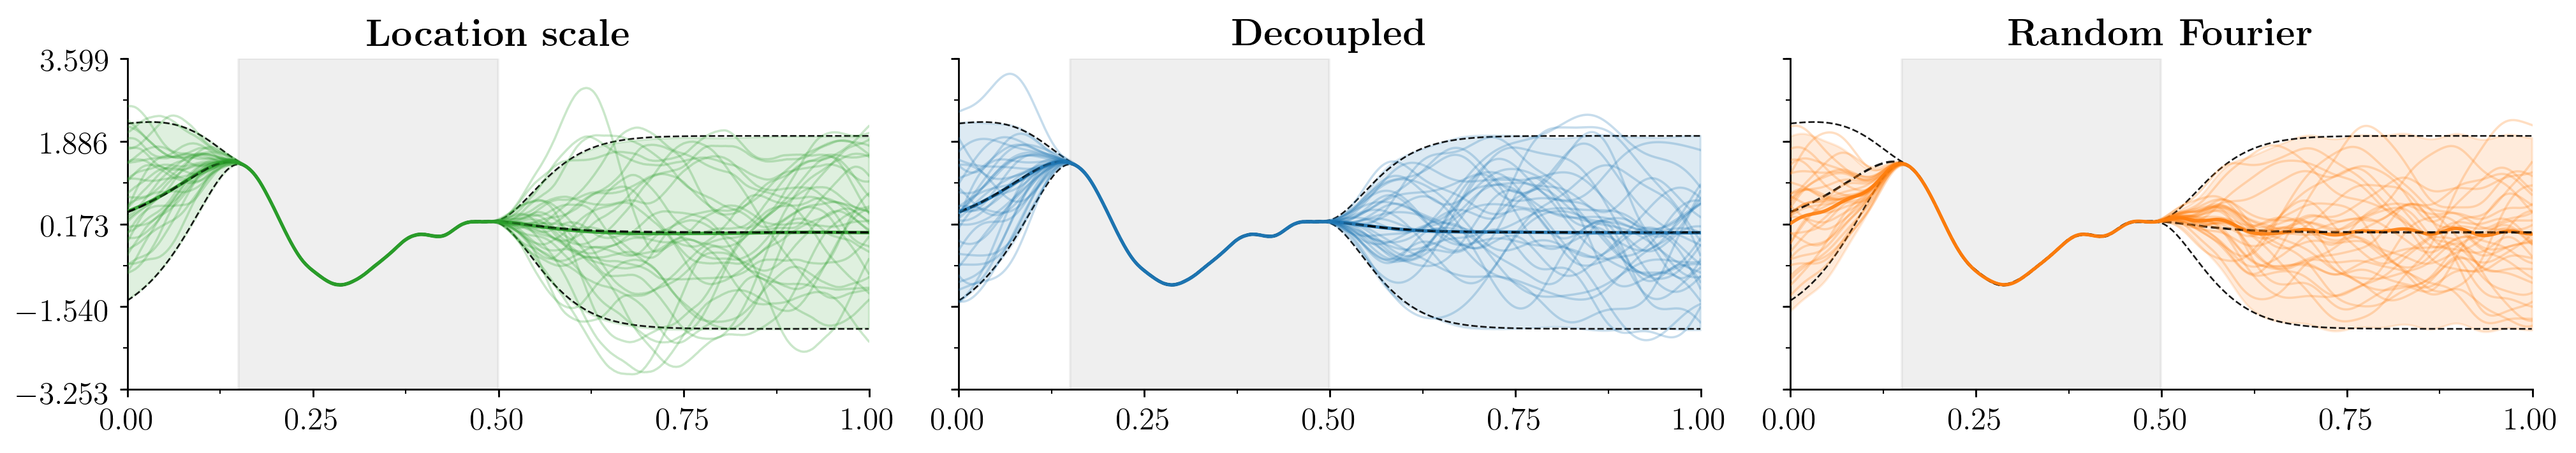

In [9]:
style = AttrDict()
style.rff = ObjectStyle(color='tab:orange', label='Random Fourier')
style.loc = ObjectStyle(color='tab:green', label='Location scale')
style.dec = ObjectStyle(color='tab:blue', label='Decoupled')
style.gold_standard = ObjectStyle(color='k', linestyle='--', label='Gold standard')

# Compare moments of gold standard posterior with empirical estimates (and samples)
fig, axes = plt.subplots(figsize=(16, 3), ncols=len(samplers), sharey='all')
indices = np.random.choice(num_samples, size=32, replace=False)
for i, (ax, (name, _samples)) in enumerate(zip(axes, samples.items())):
    ax.set_title(f'$\\textbf{{{style[name].label}}}$')

    _mf, _vf = tf.nn.moments(_samples, axes=[0])
    _sf = tf.sqrt(_vf)        
    with set_temporary_ax(ax):
        plot_line(Xnew, _mf, **style[name])
        plot_fill(Xnew, _mf - 2 * _sf, _mf + 2 * _sf, **style[name].omit('label'))

        plot_line(Xnew, mf, linewidth=1.0, **style.gold_standard)
        plot_line(Xnew, mf - 2 * sf, linewidth=0.75, **style.gold_standard.omit('label'))
        plot_line(Xnew, mf + 2 * sf, linewidth=0.75, **style.gold_standard.omit('label'))

        for k, fvals in enumerate(tf.gather(_samples, indices)):
            plot_line(Xnew, fvals, linewidth=1.0, alpha=0.25, color=style[name].color)

# Fill-in observed region of the space and tidy-up subplot axes
ylim = ax.get_ylim()
for ax in axes:
    with set_temporary_ax(ax):
        format_axes(xlim=(0, 1), ylim=ylim, num_major=5, num_minor=9, despine=True)
        plot_fill([tf.reduce_min(X), tf.reduce_max(X)], *ylim,
                  label='Observations',
                  color='silver',
                  alpha=0.25)

plt.tight_layout()